<a href="https://colab.research.google.com/github/santiago20054/Experian/blob/main/ExperianAdmissionTest2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
import collections
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
from datetime import datetime

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

#Análisis descriptivo

Empezamos por leer la base de datos. Para esto la importamos a pandas para convertirla en un objeto dataframe.

In [ ]:
df = pd.read_csv('Anonimizada_BasePruebaIngreso.csv')
df_original=df.copy()

Observamos las primeras 5 filas del dataframe

In [ ]:
df.head()

,Identificador,periodo,DIAS1,DIAS2,DIAS3,DIAS4,DIAS5,DIAS6,DIAS0,Numero_Producto,...,Saldo1,Saldo_Mora3,Saldo2,Saldo_Mora4,Saldo3,Saldo_Mora5,Saldo4,Saldo_Mora6,Saldo5,Saldo6
0,92966525716,201709,7.0,6.0,0.0,0.0,0.0,4.0,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,92967390638,201709,0.0,0.0,0.0,0.0,0.0,0.0,0,1,...,"14493557,79","294570,52","14383360,76","294569,96","14271872,86","294569,05","14159078,99","294567,62","14044963,84","13929511,94"
2,92967489284,201712,0.0,0.0,0.0,0.0,0.0,0.0,0,1,...,NaN,0,0,12262,3524442,49553,"3516034,8",41122,"2989794,73","2830734,73"
3,92966459151,201809,0.0,0.0,0.0,0.0,0.0,NaN,0,2,...,9738321.38,32433,32433,32433,32433,32433,32433,32433,32433,0
4,92966529824,201712,0.0,0.0,0.0,0.0,0.0,5.0,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observamos algunas características de las columnas de la base

In [ ]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Identificador    30000 non-null  int64  
 1   periodo          30000 non-null  int64  
 2   DIAS1            29213 non-null  float64
 3   DIAS2            28616 non-null  float64
 4   DIAS3            28070 non-null  float64
 5   DIAS4            27369 non-null  float64
 6   DIAS5            26792 non-null  float64
 7   DIAS6            22642 non-null  float64
 8   DIAS0            30000 non-null  int64  
 9   Numero_Producto  30000 non-null  int64  
 10  GENERO           23819 non-null  object 
 11  Saldo_Mora1      21592 non-null  object 
 12  Cupo             21592 non-null  object 
 13  Saldo_Mora2      22213 non-null  object 
 14  Saldo1           22213 non-null  object 
 15  Saldo_Mora3      22877 non-null  object 
 16  Saldo2           22877 non-null  object 
 17  Saldo_Mora4 

Como podemos observar algunas columnas que deberían ser númericas están marcadas como objetos. Además de eso, tenemos varios datos nulos o vacíos. 

In [ ]:
df.isna().any()

Identificador      False
periodo            False
DIAS1               True
DIAS2               True
DIAS3               True
DIAS4               True
DIAS5               True
DIAS6               True
DIAS0              False
Numero_Producto    False
GENERO              True
Saldo_Mora1         True
Cupo                True
Saldo_Mora2         True
Saldo1              True
Saldo_Mora3         True
Saldo2              True
Saldo_Mora4         True
Saldo3              True
Saldo_Mora5         True
Saldo4              True
Saldo_Mora6         True
Saldo5              True
Saldo6              True
dtype: bool

## Limpieza de datos

Procedemos a limpiar la base de datos. Para esto, eliminarémos los datos vacíos o nulos

In [ ]:
for i in range(0, df.shape[1]):
  df.dropna(axis=0, how='all', subset=[df.iloc[:,i].name], inplace=True)

Verificamos si tenemos algún dato nulo en el data frame

In [ ]:
df.isnull().sum()

Identificador      0
periodo            0
DIAS1              0
DIAS2              0
DIAS3              0
DIAS4              0
DIAS5              0
DIAS6              0
DIAS0              0
Numero_Producto    0
GENERO             0
Saldo_Mora1        0
Cupo               0
Saldo_Mora2        0
Saldo1             0
Saldo_Mora3        0
Saldo2             0
Saldo_Mora4        0
Saldo3             0
Saldo_Mora5        0
Saldo4             0
Saldo_Mora6        0
Saldo5             0
Saldo6             0
dtype: int64

In [ ]:
df.shape

(13227, 24)

Los registros pasaron de 30000 a 13227 eliminando filas con valores vacíos.
Vamos ahora a eliminar valores duplicados por ID.

In [ ]:
df=df.drop_duplicates(['Identificador'], keep='last')
df=df.reset_index()
df=df.drop(columns=['index'])
print(df.shape)

(10034, 24)


Ahora, removiendo los duplicados, pasamos a tener 10034 registros.
Continuamos a convertir las variables mal clasificadas en enteras y float.

In [ ]:
def string_to_float(string): 
  return float(re.sub(r'[^\w\s]','',string))
for i in range(11, 24):
  df.iloc[:,i]=df.iloc[:, i].apply(string_to_float)
for i in range(2, 8):
  df.iloc[:,i]=df.iloc[:, i].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10034 entries, 0 to 10033
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Identificador    10034 non-null  int64  
 1   periodo          10034 non-null  int64  
 2   DIAS1            10034 non-null  int64  
 3   DIAS2            10034 non-null  int64  
 4   DIAS3            10034 non-null  int64  
 5   DIAS4            10034 non-null  int64  
 6   DIAS5            10034 non-null  int64  
 7   DIAS6            10034 non-null  int64  
 8   DIAS0            10034 non-null  int64  
 9   Numero_Producto  10034 non-null  int64  
 10  GENERO           10034 non-null  object 
 11  Saldo_Mora1      10034 non-null  float64
 12  Cupo             10034 non-null  float64
 13  Saldo_Mora2      10034 non-null  float64
 14  Saldo1           10034 non-null  float64
 15  Saldo_Mora3      10034 non-null  float64
 16  Saldo2           10034 non-null  float64
 17  Saldo_Mora4 

Ahora, ordenamos las columnas de la forma en cómo se presentan en la descripción. 

In [ ]:
df = df.reindex(columns=['Identificador','periodo','DIAS0','DIAS1','DIAS2','DIAS3', 'DIAS4', 'DIAS5', 'DIAS6',
                         'Numero_Producto', 'GENERO', 'Saldo_Mora1', 'Saldo_Mora2', 'Saldo_Mora3', 'Saldo_Mora4',
                         'Saldo_Mora5', 'Saldo_Mora6', 'Cupo', 'Saldo1', 'Saldo2', 'Saldo3', 'Saldo4', 'Saldo5', 'Saldo6'])

Pasemos a mirar algunas características descriptivas de nuestros datos.

In [ ]:
df.iloc[:,2:].describe()

,DIAS0,DIAS1,DIAS2,DIAS3,DIAS4,DIAS5,DIAS6,Numero_Producto,Saldo_Mora1,Saldo_Mora2,...,Saldo_Mora4,Saldo_Mora5,Saldo_Mora6,Cupo,Saldo1,Saldo2,Saldo3,Saldo4,Saldo5,Saldo6
count,10034.000000,10034.000000,10034.000000,10034.000000,10034.000000,10034.000000,10034.000000,10034.000000,1.003400e+04,1.003400e+04,...,1.003400e+04,1.003400e+04,1.003400e+04,1.003400e+04,1.003400e+04,1.003400e+04,1.003400e+04,1.003400e+04,1.003400e+04,1.003400e+04
mean,10.614212,11.162547,12.631652,13.906020,16.687961,18.795994,20.922065,1.436217,1.457278e+07,3.110904e+10,...,1.063713e+11,7.568642e+10,7.420037e+10,5.297769e+11,3.893328e+11,6.034055e+11,2.329785e+11,1.792082e+11,4.484168e+11,3.679107e+11
std,19.834533,25.748757,31.037328,36.397534,43.178023,49.914129,56.168051,0.972649,1.155137e+08,2.252168e+12,...,8.260151e+12,7.579718e+12,7.430854e+12,1.996000e+13,1.403737e+13,1.981178e+13,9.246639e+12,7.347073e+12,1.638041e+13,1.382161e+13
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.989245e+06,9.915256e+06,1.203272e+07,1.116191e+07,1.293424e+07,1.467884e+07,1.488652e+07
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.486350e+04,1.779850e+04,...,1.930700e+04,2.065500e+04,2.145900e+04,2.524516e+08,2.574184e+08,2.629732e+08,2.636392e+08,2.668281e+08,2.741291e+08,2.687241e+08
75%,10.000000,3.000000,4.000000,2.000000,4.000000,2.000000,3.000000,2.000000,9.180525e+04,1.240805e+05,...,1.224135e+05,1.628508e+05,1.605042e+05,1.361345e+09,1.361551e+09,1.357375e+09,1.359062e+09,1.310278e+09,1.334222e+09,1.290378e+09
max,90.000000,124.000000,154.000000,183.000000,215.000000,246.000000,274.000000,14.000000,6.216763e+09,1.893820e+14,...,7.736272e+14,7.592592e+14,7.443476e+14,9.685770e+14,9.307980e+14,9.973579e+14,6.855217e+14,4.558653e+14,9.888720e+14,9.007961e+14


Podemos ver algunas gráficas interesantes para describrir nuestros datos como el porcentaje de mujeres y hombres en nuesta base de datos.

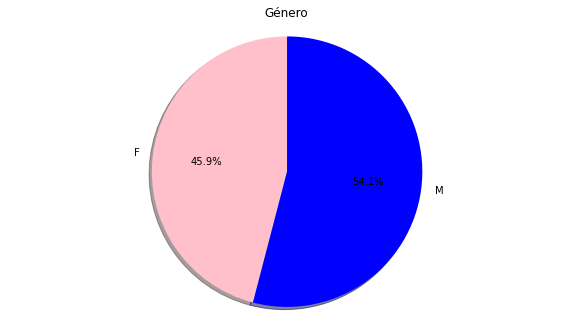

In [ ]:
labels = 'F', 'M'
sizes = [df['GENERO'].value_counts()[1],df['GENERO'].value_counts()[0]]
colors = ['pink','blue']
explode = (0, 0)
fig1, ax1 = plt.subplots(figsize =(10,5.5))
ax1.pie(sizes,colors = colors ,explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Género")
plt.show()

Tambien podemos ver cuántos productos se han adquirido por género.

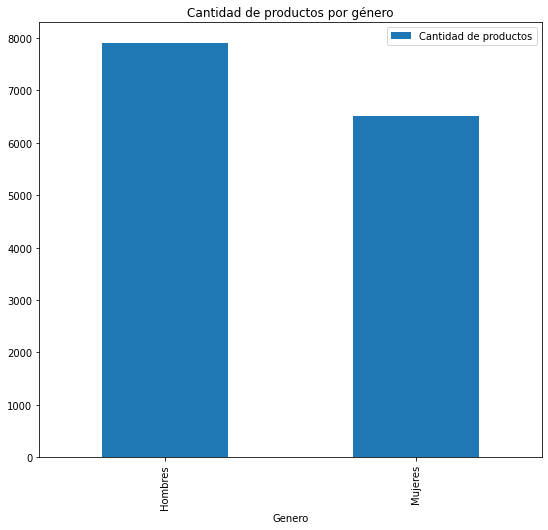

In [ ]:
data=[["Hombres", df['Numero_Producto'][df['GENERO']=='M'].sum()],
      ["Mujeres", df['Numero_Producto'][df['GENERO']=='F'].sum()],
     ]
df_2=pd.DataFrame(data,columns=["Genero","Cantidad de productos"])
df_2.plot(x="Genero", y=["Cantidad de productos"], kind="bar",figsize=(9,8))
plt.title("Cantidad de productos por género")
plt.show()

También podemos observar de manera interactiva seleccionando diferentes tipos de dias y saldos, el promedio de días en mora y saldos de los clientes.

In [ ]:
df['periodo']=df['periodo'].astype(int)
table_2=['DIAS0',	'DIAS1',	'DIAS2',	'DIAS3',	'DIAS4',	'DIAS5',	'DIAS6']
def f_2(Format):
  x= ['2017', '2018']

  if Format=='DIAS0':
    y=[df['DIAS0'][df['periodo']==201709].mean()+df['DIAS0'][df['periodo']==201712].mean(), df['DIAS0'][df['periodo']==201803].mean()+
       df['DIAS0'][df['periodo']==201806].mean()]

  if Format=='DIAS1':
    y=[df['DIAS1'][df['periodo']==201709].mean()+ df['DIAS1'][df['periodo']==201712].mean(), df['DIAS1'][df['periodo']==201803].mean()+
       df['DIAS1'][df['periodo']==201806].mean()]

  if Format=='DIAS2':
    y=[df['DIAS2'][df['periodo']==201709].mean()+ df['DIAS2'][df['periodo']==201712].mean(), df['DIAS2'][df['periodo']==201803].mean()+
       df['DIAS2'][df['periodo']==201806].mean()]

  if Format=='DIAS3':
    y=[df['DIAS3'][df['periodo']==201709].mean()+ df['DIAS3'][df['periodo']==201712].mean(), df['DIAS3'][df['periodo']==201803].mean()+
       df['DIAS3'][df['periodo']==201806].mean()]

  if Format=='DIAS4':
    y=[df['DIAS4'][df['periodo']==201709].mean()+ df['DIAS4'][df['periodo']==201712].mean(), df['DIAS4'][df['periodo']==201803].mean()+
       df['DIAS4'][df['periodo']==201806].mean()]

  if Format=='DIAS5':
    y=[df['DIAS5'][df['periodo']==201709].mean()+ df['DIAS5'][df['periodo']==201712].mean(), df['DIAS5'][df['periodo']==201803].mean()+
       df['DIAS5'][df['periodo']==201806].mean()]
  
  if Format=='DIAS6':
    y=[df['DIAS6'][df['periodo']==201709].mean()+ df['DIAS6'][df['periodo']==201712].mean(), df['DIAS6'][df['periodo']==201803].mean()+
       df['DIAS6'][df['periodo']==201806].mean()]
  

  fig = px.line(x=x, y=y, markers=True, labels={
                     "x":"Año",
                      "y":"Promedio de días en mora"},
               title="Promedio de días en mora de los clientes a traves del tiempo")
  fig.show()

interact(f_2, Format=table_2)

interactive(children=(Dropdown(description='Format', options=('DIAS0', 'DIAS1', 'DIAS2', 'DIAS3', 'DIAS4', 'DI…

<function __main__.f_2>

In [ ]:
df['periodo']=df['periodo'].astype(int)
table_2=['Saldo_Mora1',	'Saldo_Mora2',	'Saldo_Mora3','Saldo_Mora4',	'Saldo_Mora5',	'Saldo_Mora6']
def f_2(Format):
  x= ['2017', '2018']

  if Format=='Saldo_Mora1':
    y=[df['Saldo_Mora1'][df['periodo']==201709].mean()+df['Saldo_Mora1'][df['periodo']==201712].mean(), 
       df['Saldo_Mora1'][df['periodo']==201803].mean()+df['Saldo_Mora1'][df['periodo']==201806].mean()]

  if Format=='Saldo_Mora2':
    y=[df['Saldo_Mora2'][df['periodo']==201709].mean()+df['Saldo_Mora2'][df['periodo']==201712].mean(), 
       df['Saldo_Mora2'][df['periodo']==201803].mean()+df['Saldo_Mora2'][df['periodo']==201806].mean()]

  if Format=='Saldo_Mora3':
    y=[df['Saldo_Mora3'][df['periodo']==201709].mean()+df['Saldo_Mora3'][df['periodo']==201712].mean(), 
       df['Saldo_Mora3'][df['periodo']==201803].mean()+df['Saldo_Mora3'][df['periodo']==201806].mean()]

  if Format=='Saldo_Mora4':
    y=[df['Saldo_Mora4'][df['periodo']==201709].mean()+df['Saldo_Mora4'][df['periodo']==201712].mean(), 
       df['Saldo_Mora4'][df['periodo']==201803].mean()+df['Saldo_Mora4'][df['periodo']==201806].mean()]

  if Format=='Saldo_Mora5':
    y=[df['Saldo_Mora5'][df['periodo']==201709].mean()+df['Saldo_Mora5'][df['periodo']==201712].mean(), 
       df['Saldo_Mora5'][df['periodo']==201803].mean()+df['Saldo_Mora5'][df['periodo']==201806].mean()]

  if Format=='Saldo_Mora6':
    y=[df['Saldo_Mora6'][df['periodo']==201709].mean()+df['Saldo_Mora6'][df['periodo']==201712].mean(), 
       df['Saldo_Mora6'][df['periodo']==201803].mean()+df['Saldo_Mora6'][df['periodo']==201806].mean()]
  

  fig = px.line(x=x, y=y, markers=True, labels={
                     "x":"Año",
                      "y":"Promedio de saldo en mora"},
               title="Promedio de saldo en mora de los clientes a traves del tiempo")
  fig.show()

interact(f_2, Format=table_2)

interactive(children=(Dropdown(description='Format', options=('Saldo_Mora1', 'Saldo_Mora2', 'Saldo_Mora3', 'Sa…

<function __main__.f_2>

# Construcción de variables

## Saldo promedio de los últimos seis meses

In [ ]:
df['Saldo promedio']=(df['Saldo1']+ df['Saldo2']+df['Saldo3']+df['Saldo4']+df['Saldo5']+df['Saldo6'])/6

##  Saldo máximo en el primer trimestre

In [ ]:
df['Saldo max 1T'] = df[['Saldo1','Saldo2','Saldo3']].max(axis=1)

## Antigüedad de la obligación en meses a 201908

In [ ]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def meses(F_inicio, F_final):
  F_inicio = datetime.strptime(F_inicio, "%Y%m")
  F_final = datetime.strptime(F_final, "%Y%m")

  return diff_month(F_final, F_inicio)

In [ ]:
df['periodo']=df['periodo'].astype(str)
df['Antiguedad']=0

In [ ]:
for i in range(0, len(df['periodo'])):
  df['Antiguedad'][i]=meses(df['periodo'][i], '201908')

## Cupo promedio de los primeros 3 meses, se calcula como Cupo/Número_Productos

In [ ]:
df['cupo promedio']=df['Cupo']/df['Numero_Producto']

## Flag género, tomando 1 es mujer y 0 es hombre.

In [ ]:
df['flag genero']=df['GENERO'].replace(['F','M'],[1,0])

# Variables binarias

## Clientes malos: Aquellos que luego de los 6 meses hayan alcanzado un máximo de 30 días en mora

In [ ]:
df['calificacion']=np.where(df['DIAS6']>=30, 1, 0)

Se selecciona esta variable pues considero que 30 días en mora es suficiente tiempo para determinar si un cliente es bueno o malo. 

# Regresión Logísitica

Primero definimos las variables para el modelo

In [ ]:
response = df['calificacion']
dataset = df[['Saldo promedio', 'Saldo max 1T', 'Antiguedad', 'cupo promedio', 'flag genero']]

In [ ]:
response.value_counts()

0    8562
1    1472
Name: calificacion, dtype: int64

Separamos la base en entrenamiento y validación

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset, response, stratify=response, test_size = 0.2)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (8027, 5)
Number transactions y_train dataset:  (8027,)
Number transactions X_test dataset:  (2007, 5)
Number transactions y_test dataset:  (2007,)


Estandarizamos los valores

In [ ]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

Corremos un primer modelo de regresión logística con todos los valores por defecto

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

results = pd.DataFrame([['Logistic Regression', 
acc, prec, rec, f1, f2]], columns = ['Model', 
'Accuracy', 'Precision', 'Recall', 'F1 Score', 
'F2 Score'])
results = results.sort_values(["Precision", 
"Recall", "F2 Score"], ascending = False)
print (results)

                 Model  Accuracy  Precision  Recall  F1 Score  F2 Score
0  Logistic Regression  0.852018        0.0     0.0       0.0       0.0


Text(0.5, 15.0, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

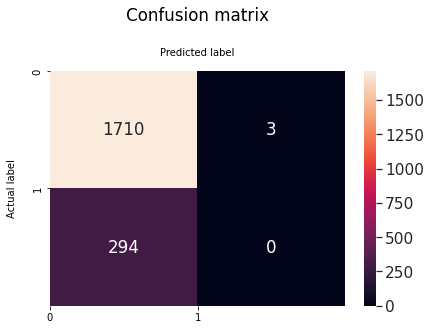

In [ ]:
cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

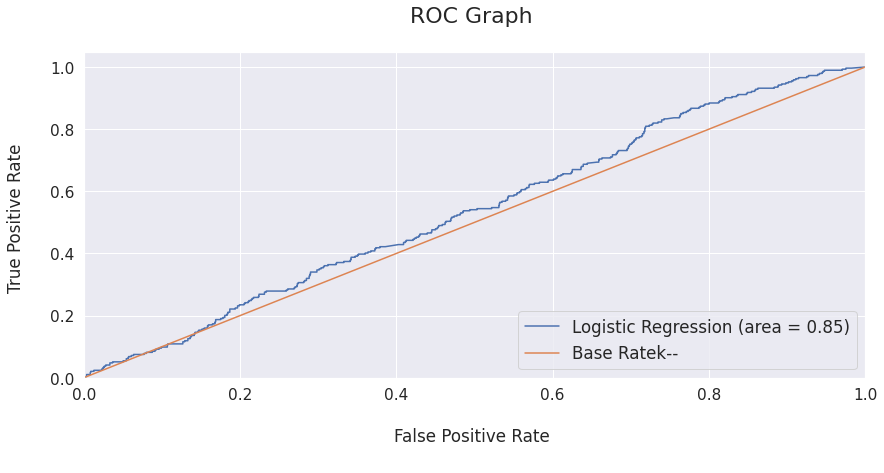

In [ ]:
from sklearn.metrics import auc, roc_auc_score, roc_curve
classifier.fit(X_train, y_train) 
probs = classifier.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, 
label='Logistic Regression (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

In [ ]:
feature_importances = pd.concat([
pd.DataFrame(dataset.columns, columns = ["features"]),
pd.DataFrame(np.transpose(classifier.coef_), 
columns = ["coef"])],axis = 1)
feature_importances.sort_values("coef", ascending = False)

,features,coef
0,Saldo promedio,0.105244
2,Antiguedad,0.073097
3,cupo promedio,0.023502
1,Saldo max 1T,-0.027078
4,flag genero,-0.097360


Se puede observar que aunque el Saldo promedio es la variable que más resulta predictiva para el modelo, ninguna de las variables seleccionadas es capaz de tener un gran aporte en la predicción de la variable de respuesta. Así mismo, los valores de recall y precisión son muy bajos aunque el accuracy sea de 0.85

Podemos ver que el modelo está calculando demasiados falsos negativos. No tenemos ningún verdadero negativo.

La tasa de malos de toda la tabla es la siguiente:

In [ ]:
round((len(response[response==1])/len(response))*100,2)

14.67

Usarémos GridSearchCV para encontrar los mejores parametros del modelo e intentarémos ejectuarlo de nuevo.

In [ ]:
def print_best_model(model):
    """
    Prints the best parameteres, score and estimator for the model given.
    """
    print(f"The best parameters are: {model.best_params_}")
    print(f"The best model score is: {model.best_score_}")    
    print(f"The best estimator is: {model.best_estimator_}")
def get_scores(y, predicted, predicted_proba):
    """
    returns the roc auc scores for the given predictions
    """
    auc_score = roc_auc_score(y, predicted)
    fpr_df, tpr_df, _ = roc_curve(y, predicted_proba) 
    return auc_score, fpr_df, tpr_df
def get_confusion_matrix(y_test, y_predicted):
    plt.figure()
    random_confusion = confusion_matrix(y_test, y_predicted)
    ax = sns.heatmap(random_confusion, annot=True, cmap="YlGnBu");
    ax.set_ylim([0,2]);

In [ ]:
param_grid_log = {
    'C': [0.1, 1, 10, 50, 100, 200],
    'max_iter': [200, 300],
    'penalty': ['l2'],
    'tol':[0.00001, 0.0001],
}
log_first = LogisticRegression(solver='lbfgs')
log_grid = GridSearchCV(log_first, param_grid=param_grid_log, cv=10, verbose=1, n_jobs=-2)
log_grid.fit(dataset, response)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-2,
             param_grid={'C': [0.1, 1, 10, 50, 100, 200],
                         'max_iter': [200, 300], 'penalty': ['l2'],
                         'tol': [1e-05, 0.0001]},
             verbose=1)

In [ ]:
print_best_model(log_grid)

The best parameters are: {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'tol': 1e-05}
The best model score is: 0.8477156180859812
The best estimator is: LogisticRegression(C=0.1, max_iter=200, tol=1e-05)


In [ ]:
best_log_estimator = LogisticRegression(C=100, 
                                        max_iter=200, 
                                        penalty='l2', 
                                        tol=1e-05, 
                                        solver='lbfgs')

best_log_estimator.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=200, tol=1e-05)

In [ ]:
log_predict_test = best_log_estimator.predict(X_test)
accuracy_score(y_test, log_predict_test)
print(classification_report(y_test, log_predict_test))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1713
           1       0.00      0.00      0.00       294

    accuracy                           0.85      2007
   macro avg       0.43      0.50      0.46      2007
weighted avg       0.73      0.85      0.79      2007



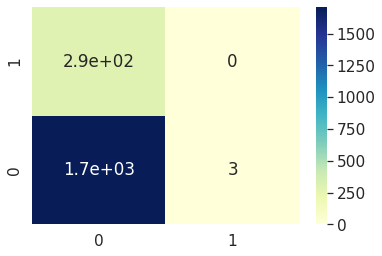

In [ ]:
get_confusion_matrix(y_test, log_predict_test)

Desafortunadamente, el desempeño del modelo no mejoró por lo que podríamos pensar que las variables seleccionadas no son las más adecuadas para predecir la variable de respuesta.

# Tablas de validación

**a. ¿Qué es un Score de Riesgo?**

Un Score de Riesgo consiste en asignarle un puntaje a un potencial deudor que a su vez, representa una estimación del desempeño del crédito para el banco. Se basa en la información del informe de crédito sobre las experiencias de crédito previas de un potencial deudor, como el historial de pago, las acciones de cobranza o las deudas pendientes, y determina qué tan viable es otorgar este crédito al solicitante. 

**b. ¿Qué es una tabla de validación?**

Es una tabla de referencia en la que se comprueba el score de riesgo de un cliente. 

**c. ¿Para qué sirven?**

Estas tablas sirven para comprobar qué tan viable es otorgar un crédito a un cliente.

**d. ¿Qué diferencia tiene una Tabla de Originación de una de Mantenimiento?**

La tabla de originicación califica la aptitud de un solicitante de crédito para cumplir contractualmente con las obligaciones de pago que asumiría si el crédito le fuera otorgado. La tabla muestra información brindada por el aspirante a crédito recibida a través de alguna solicitud, entrevista o documentos varios entregados y sometidos a validación. Mientras que la tabla de comportamiento permite dar seguimiento periódico al comportamiento del deudor a través de una calificación. Esta pretende calificar al deudor periódicamente, según su progresiva probabilidad de pago tras el otorgamiento.

**e. ¿En qué fechas fueron calculados los scores para la construcción de estas Tablas?**

Julio de 2017 y Julio de 2018.

**f. Tomando como referencia la Tabla 2, cuál es la tasa de Morosidad (a Mora 90+) de la Cartera Bancaria a Julio de 2018**

12.38%

**g. ¿Qué es el KS?** 

Es el estadístico de Komogorov Smirnov. Consiste en medir cuan distintas son las funciones de distribución de buenos y malos clientes para cada valor de puntaje score. 

**h. ¿Un KS de 42,05% para Originación es bueno o es malo?**

Se considera que un modelo con un KS menor a 20% debe ser cuestionado y mayor a 70% sea, probablemente, muy bueno para ser cierto 
(Anderson 2007, 196). TransUnion, empresa líder en gestión de la información de crédito, mide la efectividad de sus scores de riesgos de acuerdo con los siguientes estándares internacionales: 
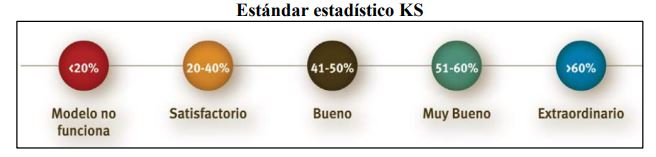

Por tanto, podríamos considerar un KS de 42.05% como bueno.

**i. Un KS de 58,64% para Comportamiento, ¿qué tal es?**

Teniendo en cuenta mi respuesta anterior, podemos decir que este es un puntaje de KS muy bueno.

**j. ¿Qué quiere decir que el Score ordena a los clientes? ¿En qué parte de la Tabla (tomar cualquiera de las dos) puedo evidenciar esto?**

Esto se puede evidenciar en la columna de Score, donde hay algunos rangos oredenador de mayor a menor, con los puntajes más altos en la parte superior de la tabla Des esta forma se puede ordenar y categorizar a los clientes.

**k. Interprete la razón de odds (buenos/malos) para el rango que contiene el punto de corte.**

Interpretando los odds y teniendo el valor de odds para el rango que contiene el punto de corte, podemos decir que para los Odds de M90 es 18.5 veces más probable que alguien sea un buen cliente a que no lo sea. Y para los odds Acum, es 40.42 veces más probable que alguien sea un buen cliente a que no lo sea.

**l. Suponga que la entidad bancaria desea aprobar más créditos y su punto de Corte es C1.**

Colocaría el punto de corte en el rango de score de 700 a a 719 para asegurar por lo menos que el valor de odds Acum sea mayor a 30 y por tanto, que por lo menos sea 30 veces más probable que alguien sea un buen cliente a que no lo sea. 